In [1]:
!pip install torch torchvision torchaudio transformers pandas scikit-learn matplotlib seaborn


  Using cached safetensors-0.5.3-cp38-abi3-win_amd64.whl.metadata (3.9 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
   ---------------------------------------- 0.0/11.2 MB ? eta -:--:--
    --------------------------------------- 0.3/11.2 MB ? eta -:--:--
   --- ------------------------------------ 1.0/11.2 MB 2.5 MB/s eta 0:00:05
   ---- ----------------------------------- 1.3/11.2 MB 2.6 MB/s eta 0:00:04
   ------- -------------------------------- 2.1/11.2 MB 2.6 MB/s eta 0:00:04
   -------- ------------------------------- 2.4/11.2 MB 2.4 MB/s eta 0:00:04
   ---------- ----------------------------- 2.9/11.2 MB 2.5 MB/s eta 0:00:04
   ------------ --------------------------- 3.4/11.2 MB 2.5 MB/s eta 0:00:04
   -------------- ------------------------- 3.9/11.2 MB 2.4 MB/s eta 0:00:03
   --------------- ------------------------ 4.5/11.2 MB 2.5 MB/s eta 0:00:03
   ----------------- ---------------------- 5.0/11.2 MB 2.5 MB/s eta 0:00:03
   --------------------- ------

In [2]:
!pip install pandas

In [3]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report
from torch.nn.functional import softmax
import matplotlib.pyplot as plt
import seaborn as sns

c:\Users\kaisy\anaconda3\envs\rekomendasi\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Load CSV
df_labels = pd.read_csv("train_labels.csv")
df_articles = pd.read_csv("parsed_articles_train_clean.csv")

# Gabungkan data berdasarkan article_id
df = pd.merge(df_labels, df_articles, on="article_id", how="inner")

# Hapus label 'Missing'
df = df[df['type'] != 'Missing']
df['label'] = df['type'].map({'Primary': 0, 'Secondary': 1})

In [5]:
df.head()

,article_id,dataset_id,type,abstract,body,label
0,10.1002_2017jc013030,https://doi.org/10.17882/49388,Primary,NaN,NaN,0
12,10.1002_ece3.4466,https://doi.org/10.5061/dryad.r6nq870,Primary,Abstract Sex determination in Australian agami...,INTRODUCTION The fundamental biological proces...,0
13,10.1002_ece3.5260,https://doi.org/10.5061/dryad.2f62927,Primary,Abstract Targeted capture and enrichment appro...,INTRODUCTION The phylogenomics revolution is u...,0
15,10.1002_ece3.6144,https://doi.org/10.5061/dryad.zw3r22854,Primary,Abstract There is urgent need for effective an...,INTRODUCTION Marine ecosystems can change rapi...,0
16,10.1002_ece3.6303,https://doi.org/10.5061/dryad.37pvmcvgb,Primary,Abstract Polyploidy can cause variation in pla...,INTRODUCTION Invasions by exotic plant species...,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 618 entries, 0 to 841
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   article_id  618 non-null    object
 1   dataset_id  618 non-null    object
 2   type        618 non-null    object
 3   abstract    470 non-null    object
 4   body        468 non-null    object
 5   label       618 non-null    int64 
dtypes: int64(1), object(5)
memory usage: 33.8+ KB


In [7]:
df.describe()

,label
count,618.000000
mean,0.684466
std,0.465105
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [8]:
df.duplicated().sum()

np.int64(0)

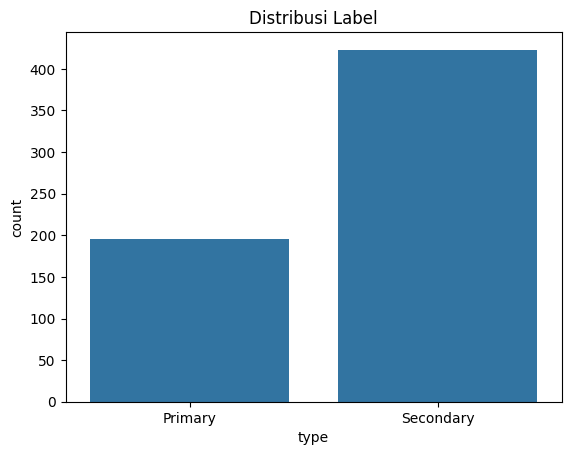

In [9]:
# Distribusi label
sns.countplot(x='type', data=df)
plt.title("Distribusi Label")
plt.show()

In [10]:
# Inisialisasi Tokenizer dari Hugging Face
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Ekstrak teks dan label dari DataFrame
texts = df['body'].fillna("").tolist()
labels = df['label'].tolist()

# Bagi data menjadi set pelatihan dan validasi sebelum tokenisasi
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels
)

# Lakukan tokenisasi pada set pelatihan dan validasi secara terpisah
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512, return_tensors='pt')
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512, return_tensors='pt')

c:\Users\kaisy\anaconda3\envs\rekomendasi\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\kaisy\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [11]:
from torch.utils.data import Dataset
import torch

class NewsDataset(Dataset):
    def __init__(self, encodings, labels):  # dua garis bawah
        self.encodings = encodings
        self.labels = labels

    def __len__(self):  # dua garis bawah
        return len(self.labels)

    def __getitem__(self, idx):  # dua garis bawah
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }


In [12]:
train_dataset = NewsDataset(train_encodings, train_labels)
val_dataset = NewsDataset(val_encodings, val_labels)

from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)


In [13]:
from transformers import BertForSequenceClassification
from torch.optim import AdamW

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
optimizer = AdamW(model.parameters(), lr=2e-5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [14]:
model.train()

for epoch in range(3):  # ganti sesuai kebutuhan
    total_loss = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()
    print(f"Epoch {epoch + 1} - Loss: {total_loss:.4f}")


c:\Users\kaisy\anaconda3\envs\rekomendasi\lib\site-packages\torch\nn\modules\module.py:1747: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch 1 - Loss: 28.2760
Epoch 2 - Loss: 18.8492
Epoch 3 - Loss: 16.2950
